# Loan Case Prediction with Python Notebook

# Load Required Libraries

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import pylab as pl
import scipy.optimize as opt
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss

About dataset:
    
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose loan are already paid off or defaulted.

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-03-29 03:20:06--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-03-29 03:20:06 (22.8 MB/s) - ‘loan_train.csv’ saved [23101/23101]



# Load data from CSV File

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

# Convert to date time object

In [4]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data Visualization

Let’s see how many of each class is in our data set

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [1]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

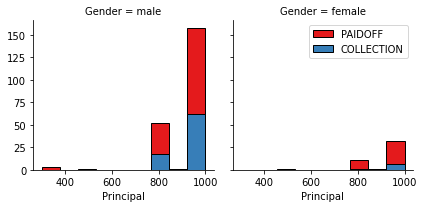

In [5]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

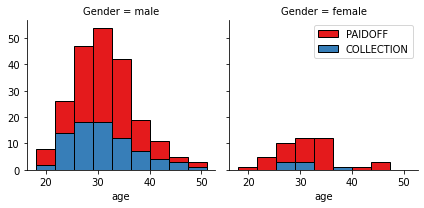

In [6]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

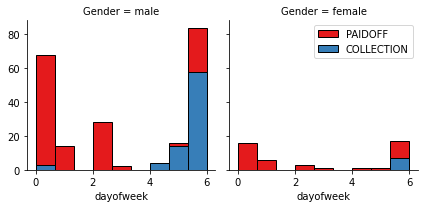

In [7]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()

In [8]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Convert Categorical features to numerical values

Lets look at gender:

In [9]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

Lets convert male to 0 and female to 1:

In [10]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [11]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame

In [13]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


# Feature selection

Lets define feature sets, X:

In [14]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [16]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Normalize Data

In [17]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Train, test and split data

In [18]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)

In [19]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]
print(accuracy_score(y_test, yhat))
print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

0.7142857142857143
              precision    recall  f1-score   support

  COLLECTION       0.45      0.56      0.50        18
     PAIDOFF       0.83      0.77      0.80        52

    accuracy                           0.71        70
   macro avg       0.64      0.66      0.65        70
weighted avg       0.74      0.71      0.72        70

[[10  8]
 [12 40]]


In [20]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8007246376811594
Test set Accuracy:  0.7142857142857143


Choosing the value of k by increasing the k value from 1 to 10

In [23]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.62857143, 0.62857143, 0.7       , 0.71428571, 0.72857143,
       0.7       , 0.75714286, 0.68571429, 0.75714286])

In [25]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7571428571428571 with k= 7


In [26]:
k = 7
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat = neigh.predict(X_test)
yhat[0:5]
print(accuracy_score(y_test, yhat))
print(classification_report(y_test, yhat))
print(confusion_matrix(y_test, yhat))

0.7571428571428571
              precision    recall  f1-score   support

  COLLECTION       0.56      0.28      0.37        18
     PAIDOFF       0.79      0.92      0.85        52

    accuracy                           0.76        70
   macro avg       0.67      0.60      0.61        70
weighted avg       0.73      0.76      0.73        70

[[ 5 13]
 [ 4 48]]


# Evaluation Metrics - KNN

In [27]:
jaccard_score(y_test, yhat,pos_label='PAIDOFF')
print ( " The KNN Jaccard Score is", jaccard_score(y_test, yhat,pos_label='PAIDOFF'))

 The KNN Jaccard Score is 0.7384615384615385


In [28]:
f1_score(y_test, yhat, average='weighted')
print ( " The KNN F-1 is", f1_score(y_test, yhat, average='weighted'))

 The KNN F-1 is 0.726337968815845


# Decision Tree

In [30]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [31]:
defTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
defTree # it shows the default parameters
#To fit
defTree.fit(X_trainset, y_trainset)
#To predict
predTree = defTree.predict(X_testset)

# Evaluation Metrics - Decision Tree

In [32]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.6538461538461539


In [33]:
print ( " The Decision Tree Jaccard Score is", jaccard_score(y_test, yhat,pos_label='PAIDOFF'))


 The Decision Tree Jaccard Score is 0.7384615384615385


In [54]:
print ( " The Decision Tree F-1 Score is", jaccard_score(y_test, yhat,pos_label='PAIDOFF'))

 The Decision Tree F-1 Score is 0.75


# Support Vector Machine

In [34]:
X = Feature
X = np.asarray(X)
X[0:5]

array([[1000,   30,   45,    0,    0,    0,    1,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

In [35]:
y = np.asarray(df['loan_status'])
y [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [36]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [37]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Evaluation Metrics - SVM

In [38]:
f1_score(y_test, yhat, average='weighted') 

0.6332552693208431

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        18
     PAIDOFF       0.74      1.00      0.85        52

    accuracy                           0.74        70
   macro avg       0.37      0.50      0.43        70
weighted avg       0.55      0.74      0.63        70

Confusion matrix, without normalization
[[52  0]
 [18  0]]


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


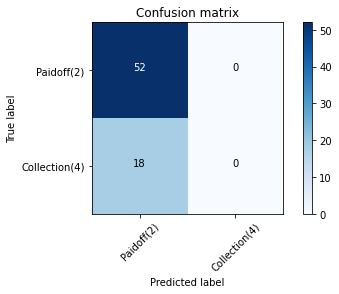

In [40]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF', 'COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Paidoff(2)','Collection(4)'],normalize= False,  title='Confusion matrix')

In [41]:
f1_score(y_test, yhat, average='weighted') 

0.6332552693208431

In [42]:
jaccard_score(y_test, yhat,pos_label='PAIDOFF')

0.7428571428571429

# Logistic Regression

In [43]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [44]:
yhat = LR.predict(X_test)
yhat

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF'], dtype=object)

In [48]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.49, 0.51],
       [0.29, 0.71],
       [0.5 , 0.5 ],
       [0.49, 0.51],
       [0.49, 0.51],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.42, 0.58],
       [0.34, 0.66],
       [0.31, 0.69],
       [0.31, 0.69],
       [0.43, 0.57],
       [0.49, 0.51],
       [0.3 , 0.7 ],
       [0.48, 0.52],
       [0.48, 0.52],
       [0.5 , 0.5 ],
       [0.32, 0.68],
       [0.41, 0.59],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.31, 0.69],
       [0.42, 0.58],
       [0.43, 0.57],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.33, 0.67],
       [0.32, 0.68],
       [0.49, 0.51],
       [0.45, 0.55],
       [0.43, 0.57],
       [0.42, 0.58],
       [0.31, 0.69],
       [0.28, 0.72],
       [0.46, 0.54],
       [0.34, 0.66],
       [0.29, 0.71],
       [0.5 , 0.5 ],
       [0.45, 0.55],
       [0.49, 0.51],
       [0.44, 0.56],
       [0.31, 0.69],
       [0.48, 0.52],
       [0.27, 0.73],
       [0.44, 0.56],
       [0.33, 0.67],
       [0.27, 0.73],
       [0.49,

In [49]:
jaccard_score(y_test, yhat,pos_label='PAIDOFF')

0.75

In [52]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.67      0.11      0.19        18
     PAIDOFF       0.76      0.98      0.86        52

    accuracy                           0.76        70
   macro avg       0.71      0.55      0.52        70
weighted avg       0.74      0.76      0.69        70



In [53]:
log_loss(y_test, yhat_prob)

0.5838106520220708

# Report

|ALGORITHM|JACCARD|F1-SCORE|LogLoss|
|----|----|----|----|
|KNN|0.74|0.73|NA|
|Decision Tree|0.74|0.75|NA|
|SVM|0.74|0.63|NA|
|LogisticRegression|0.75|0.69|0.58|